In [1]:
import os
import sys
import warnings

Path = os.path.abspath('../Models/')
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch


hostname = os.uname()
if 'tedtop' in hostname: sys.path.append('/home/fedor-tairli/work/CDEs/Dataset/')


from Dataset2 import ProcessingDatasetContainer


In [2]:
Model_Name   = 'TraceTriggerModel2_2F2F'
Dataset_Name = 'TracesDataset'

In [3]:
if 'tycho' in hostname:
    Models_Path  = '/remote/tychodata/ftairli/work/CDEs/PulseTriggering/Models'
    Dataset_Path = '/remote/tychodata/ftairli/work/CDEs/PulseTriggering/Data/'
if 'tedtop' in hostname:
    Models_Path  = '/home/fedor-tairli/work/CDEs/PulseTriggering/Models'
    Dataset_Path = '/home/fedor-tairli/work/CDEs/PulseTriggering/Code/'

# append models path to path
sys.path.append(Models_Path)

In [4]:
# Import Dataset Here
def Do_Nothing(Truth, *kwargs):
    return Truth
# datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
# Dataset = ProcessingDatasetContainer(datapath)
Dataset = torch.load(f'{Dataset_Path}/{Dataset_Name}.pt',weights_only=False)
print(Dataset.Name)
print(Dataset.Truth_Keys)
Dataset.AssignIndices()
Dataset.State = 'Test'

TracesDataset
('TraceLikeness',)


In [5]:
from TraceTriggerModel import Loss

In [6]:
Traces   = []
Weights  = []

Dataset.Batch_Size = 1000
Dataset.RandomIter = False




for _, BatchMains, BatchAux, BatchTruth, _ in Dataset:
    Traces  .append(BatchTruth)
    Weights .append(BatchAux  )

Traces  = torch.cat(Traces, dim=0)
Weights = torch.cat(Weights, dim=0)

# Weights[Weights == 0.01] = 0



In [7]:
Traces.shape

torch.Size([140800, 1, 1000])

In [8]:
# Extract the MetaData
MetaData = Dataset._MetaData[Dataset.ActiveIndeces]

In [9]:
Signal_Starts = MetaData[:,1]
Signal_Ends   = MetaData[:,2]
Signal_Centers = Signal_Starts + (Signal_Ends - Signal_Starts) // 2
Signal_Lengths = Signal_Ends - Signal_Starts
# Signal Charges would be the sum of the Traces in the window of he signal start and end
Signal_Charges = torch.zeros_like(Signal_Lengths)

for i in range(len(Signal_Starts)):
    if i % 100 == 0: print(f'Processing {i}/{len(Signal_Starts)}',end='\r')
    Signal_Charges[i] = Traces[i,0, Signal_Starts[i]:Signal_Ends[i]].sum().item()


In [10]:
def make_gaussian_batch_torch(positions, charges, widths, length=1000, device=None):
    """
    Create a batch of arrays with Gaussians placed at given positions, charges, and widths using PyTorch.

    Args:
        positions (Tensor or list): shape (N,) - centers of the Gaussians
        charges   (Tensor or list): shape (N,) - total area under each Gaussian
        widths    (Tensor or list): shape (N,) - standard deviation (sigma) for each Gaussian
        length    (int): length of each output array (default 1000)
        device    (torch.device or None): device to use

    Returns:
        Tensor: shape (N, 1, length) - batch of arrays with Gaussians
    """
    if device is None:
        device = torch.device('cpu')
    positions = torch.as_tensor(positions, dtype=torch.float32, device=device).view(-1, 1)
    charges   = torch.as_tensor(charges,   dtype=torch.float32, device=device).view(-1, 1)
    widths    = torch.as_tensor(widths,    dtype=torch.float32, device=device).view(-1, 1)
    N = positions.shape[0]
    x = torch.arange(length, device=device).view(1, -1)  # shape (1, length)
    # Compute each Gaussian in the batch
    gaussians = (charges / (torch.sqrt(2 * torch.tensor(torch.pi)) * widths)) * torch.exp(-0.5 * ((x - positions) / widths) ** 2)
    return gaussians.unsqueeze(1)  # shape (N, 1, length)

Preds = make_gaussian_batch_torch(
    positions=Signal_Centers,
    charges=Signal_Charges,
    widths=Signal_Lengths/3,  # Example width, can be adjusted
)

Plotting 13003
Square Error: 39709.15234375


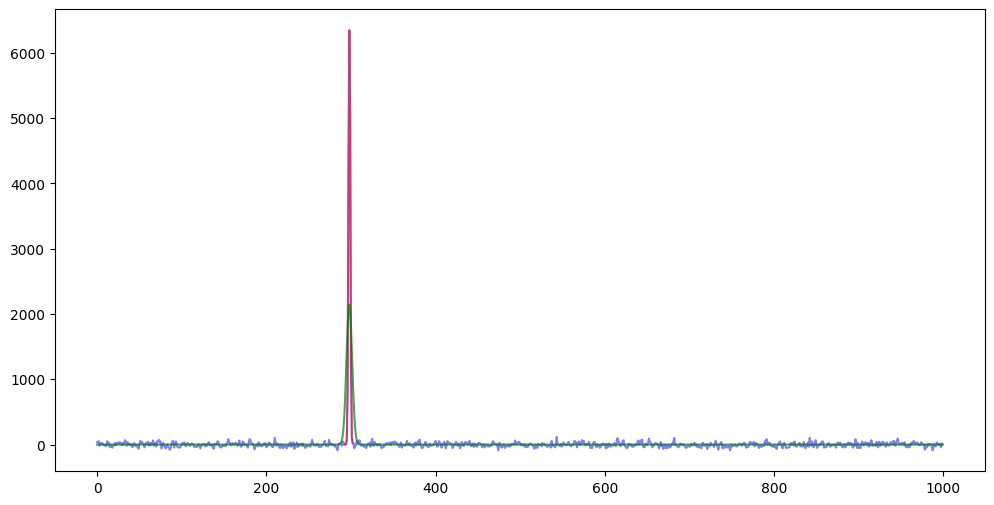

In [11]:
N = np.random.randint(0, len(Traces), 1)[0]
print(f'Plotting {N}')

plt.figure(figsize=(12, 6))
plt.plot(Traces[N,0,:].cpu().numpy(), label='Trace', color='blue', alpha=0.5)
plt.plot(range(Signal_Starts[N],Signal_Ends[N]),Traces[N,0,Signal_Starts[N]:Signal_Ends[N]].cpu().numpy(), label='Signal', color='red', alpha=0.5)
plt.plot(Preds[N,0,:].cpu().numpy(), label='Predicted Gaussian', color='green', alpha=0.7)

Square_Error = (Preds[N,0,:] - Traces[N,0,:])**2* Weights[N,0,:]
print(f'Square Error: {Square_Error.mean().item()}')
# plt.plot(Square_Error.cpu().numpy(), label='Square Error', color='orange', alpha=0.5)

In [ ]:
Square_Error = (Preds[:,0,:] - Traces[:,0,:])**2* Weights[:,0,:]

Median_Error = Square_Error.median().item()
print(f'Median Square Error: {Median_Error}')

Median Square Error: 5.051031589508057


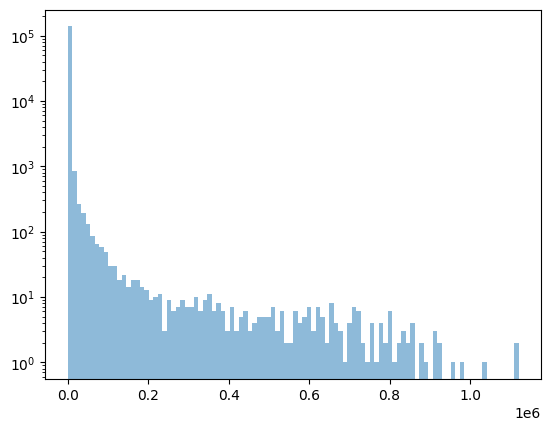

In [13]:
All_Square_Error = torch.mean((Preds[:,0,:] - Traces[:,0,:])**2* Weights[N,0,:],dim=1)
# All_Square_Error = 
plt.hist(All_Square_Error.cpu().numpy(), bins=100, alpha=0.5, label='Square Error Histogram')
plt.yscale('log')

In [14]:
Gaussian_Pred_Loss = Loss(Preds,Traces,Weights)

In [15]:
print(f'Gaussian Prediction Loss: {Gaussian_Pred_Loss}')

Gaussian Prediction Loss: {'Total': tensor(15561.1045), 'TraceLikeness': tensor(15561.1045)}


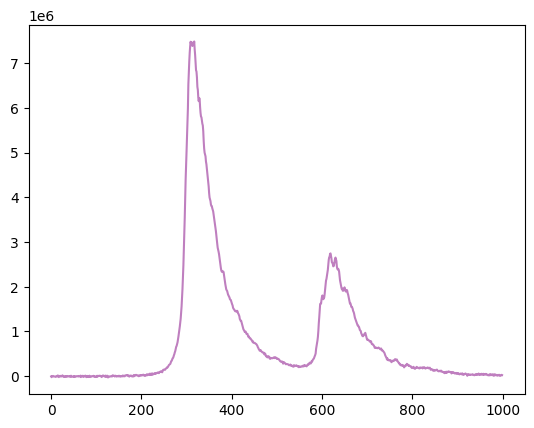

In [16]:
Truth_sum = Traces[:,0,:].sum(dim=0)
plt.plot(Truth_sum.cpu().numpy(), label='Truth Sum', color='purple', alpha=0.5)